In [1]:
import casadi as ca
import numpy as np
import cvxpy as cp
import control as ct
from matplotlib import pyplot as plt

/home/henry/venv-ardupilot/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
!pip3 list installed | grep casadi; which python3

casadi                               3.7.0
/home/henry/venv-ardupilot/bin/python3


## Theory
From https://arxiv.org/pdf/1611.09240

$$\begin{align}
\dot{\textbf{p}} &= \textbf{v}\\
\dot{\textbf{v}} &= \frac{1}{m}(\textbf{R}_{IB}\sum_{i=0}^{N_{r}}\textbf{F}_{T,i})+
\begin{bmatrix}
0 \\
0 \\
-g \\
\end{bmatrix}\\
\dot{\textbf{R}}_{IB} &= \textbf{R}_{IB}\lfloor\boldsymbol{\omega}\times\rfloor\\
\textbf{J}\dot{\boldsymbol{\omega}}&=-\boldsymbol{\omega}\times\textbf{J}\boldsymbol{\omega} + \textit{A}
\begin{bmatrix}
n_{1}^{2} \\
\vdots \\
n_{N_{r}}^{2} \\
\end{bmatrix}
\end{align}
$$

More detailed state space model, equivalent to the above from this paper: https://arxiv.org/pdf/2504.13286

$$
\begin{align}
m\ddot{X} &= F(\cos{\phi}\sin{\theta}\cos{\psi}+\sin{\phi}\sin{\psi}) \\
m\ddot{Y} &= F(\cos{\phi}\sin{\theta}\sin{\psi}+\sin{\phi}\cos{\psi}) \\
m\ddot{Z} &= F(\cos{\phi}\cos{\theta})-mg \\
I_{x}\ddot{\phi} &= T_{x}l+\dot{\theta}\dot{\psi}(I_{y}-I_{z}) \\
I_{y}\ddot{\theta} &= T_{y}l+\dot{\psi}\dot{\phi}(I_{z}-I_{x}) \\
I_{z}\ddot{\psi} &= T_{z}l+\dot{\phi}\dot{\theta}(I_{x}-I_{y}) \\
F & = F_1 + F_2 + F_3 + F_4
\end{align}
$$


In [12]:
## Dynamics
x = ca.SX.sym("x", 12)
u = ca.SX.sym("u", 4)

m = 1  # kg
g = 10  # m/s^2
Ix, Iy, Iz = 0.11, 0.11, 0.04  # kg m^2
l = 0.2  # m (this drops out when controlling via torques)
dt=0.1

parms = {"Q": np.eye(12), "R": np.eye(4), "N": 10, "Qf": np.eye(12), "dynamic": True}

# non linear dynamics
x_x, x_y, x_z, x_phi, x_theta, x_psi, x_dx, x_dy, x_dz, x_dphi, x_dtheta, x_dpsi = ca.vertsplit(x, 1)
u_F, u_Tx, u_Ty, u_Tz = ca.vertsplit(u, 1)

dx_x = x_dx
dx_y = x_dy
dx_z = x_dz
dx_phi = x_dphi
dx_theta = x_dtheta
dx_psi = x_dpsi
dx_dx = u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.cos(x_psi) + ca.sin(x_phi)*ca.sin(x_psi))
dx_dy = u_F/m * (ca.cos(x_phi)*ca.sin(x_theta)*ca.sin(x_psi)+ca.sin(x_phi)*ca.cos(x_psi))
dx_dz = u_F/m * ca.cos(x_phi) * ca.cos(x_theta) - g
dx_dphi = 1/Ix * (u_Tx + x_dtheta * x_dpsi*(Iy - Iz))
dx_dtheta = 1/Iy * (u_Ty + x_dpsi*x_dphi*(Iz - Ix))
dx_dpsi = 1/Iz * (u_Tz + x_dphi*x_dtheta*(Ix-Iy))

x_dot = ca.vertcat(dx_x, dx_y, dx_z, dx_phi, dx_theta, dx_psi, dx_dx, dx_dy, dx_dz, dx_dphi, dx_dtheta, dx_dpsi)
f = x_dot
dynamics = ca.Function("quadrotor_dyn", [x, u], [x + dt * x_dot])

# this is continuous or discrete time?
#jac_dyn_x = ca.jacobian(self.x + self.dt * x_dot, self.x)
#jac_dyn_u = ca.jacobian(self.x + self.dt * x_dot, self.u)
#self.jac_dyn_x = ca.Function("jac_dyn_x", [self.x, self.u], [jac_dyn_x])
#self.jac_dyn_u = ca.Function("jac_dyn_u", [self.x, self.u], [jac_dyn_u])

In [13]:
dynamics

Function(quadrotor_dyn:(i0[12],i1[4])->(o0[12]) SXFunction)

In [14]:
## Testing dynamics model
temp_x = np.array([0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 2, 0]).reshape(12,1)
temp_u = np.array([10, 0, 0, 0]).reshape(4,1)
for i in range(0,100):
    temp_x = dynamics(temp_x, temp_u)
print(temp_x)

[47.2939, 0, -479, 0, 20, 0, 2.49325, 0, -95.1545, 0, 2, 0]


In [15]:
## Linearization
x_operating = np.zeros((12, 1))
u_operating = np.array([9.8, 0, 0, 0]).reshape((-1, 1))  # hovering (mg 0 0 0)

A = ca.Function("A", [x, u], [ca.jacobian(f, x)])(x_operating, u_operating)
B = ca.Function("B", [x, u], [ca.jacobian(f, u)])(x_operating, u_operating)
C = np.eye(12)
D = np.zeros((12, 4))

#make numerical matrices and cast into numpy array
A = np.array(ca.DM(A))
B = np.array(ca.DM(B))

lin_ss_cont = ct.ss(A,B,C,D)
lin_ss_disc = ct.c2d(lin_ss_cont,dt,method='zoh')

print(lin_ss_disc)

<StateSpace>: sys[2]$sampled
Inputs (4): ['u[0]', 'u[1]', 'u[2]', 'u[3]']
Outputs (12): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]', 'y[6]', 'y[7]', 'y[8]', 'y[9]', 'y[10]', 'y[11]']
States (12): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]', 'x[6]', 'x[7]', 'x[8]', 'x[9]', 'x[10]', 'x[11]']

A = [[1.         0.         0.         0.         0.049      0.
      0.1        0.         0.         0.         0.00163333 0.        ]
     [0.         1.         0.         0.049      0.         0.
      0.         0.1        0.         0.00163333 0.         0.        ]
     [0.         0.         1.         0.         0.         0.
      0.         0.         0.1        0.         0.         0.        ]
     [0.         0.         0.         1.         0.         0.
      0.         0.         0.         0.1        0.         0.        ]
     [0.         0.         0.         0.         1.         0.
      0.         0.         0.         0.         0.1        0.        ]
     [0.       

In [16]:
## MPC
def mpc(x0, x_ref, u_ref, Q=np.eye(12), R=np.eye(4), N=10, Qf=np.eye(12), dynamic=False):
    x = cp.Variable((12, N))
    u = cp.Variable((4, N))
    cost = sum(cp.quad_form(x[:, i] - x_ref.T, Q) + cp.quad_form(u[:, i] - u_ref, R) for i in range(N))  # stage cost
    cost += cp.quad_form(x[:, N-1] - x_ref.T, Qf)  # terminal cost
    obj = cp.Minimize(cost)
    
    cons = [x[:, 0] == x0]
    for i in range(1, N):
        cons += [x[:, i] == lin_ss_disc.A @ x[:, i-1] + lin_ss_disc.B @ u[:, i-1]]
    
    u_max = np.array([30, 1.4715, 1.4715, 0.0196])
    u_min = np.array([-10, -1.4715, -1.4715, -0.0196])
    
    if dynamic==True:
        cons += [u <= np.array([u_max]).T, u >= np.array([u_min]).T]                            # Input limit
        cons += [x[3:5, :] <= 0.5*np.pi*np.ones((2,1)), x[3:5,:] >= -0.5*np.pi*np.ones((2, 1))]   # Pitch and roll limit
        cons += [x[6:9, :] <= 2*np.ones((3,1)), x[6:9,:] >= -2*np.ones((3, 1))]                   # Speed limit
        cons += [x[9:12, :] <= 3*np.pi*np.ones((3,1)), x[9:12,:] >= -3*np.pi*np.ones((3, 1))]     # Angular speed limit
    
    prob = cp.Problem(obj, cons)
    prob.solve(verbose=False)
    
    return u.value[:, 0], x.value

In [17]:
def step(x, x_ref, sim_system="linear", parms=None):
    # discrete step
    try:
        u_ref = np.zeros(4)
        u, _ = mpc(x, x_ref, u_ref, Q=parms["Q"], R=parms["R"], N=parms["N"], Qf=parms["Qf"], dynamic=parms["dynamic"])
    except:
        u = np.zeros(4)

    if sim_system == "linear":
        x_next = lin_ss_disc.A @ x + lin_ss_disc.B @ u
    else:
        raise ValueError("Sim system argument must be linear or non-linear.")
    return x_next, u

In [18]:
## trajectory
def hover_traj(N):
    x_x_ref = np.zeros(N)
    x_y_ref = np.zeros(N)
    x_z_ref = np.ones(N) * 10
    x_ref = np.vstack((x_x_ref, x_y_ref, x_z_ref, np.zeros((9, N))))
    return x_ref

def ramp(N):
    x_x_ref = np.zeros(N)
    x_y_ref = np.zeros(N)
    x_z_ref = np.arange(0,10,10/N)
    x_ref = np.vstack((x_x_ref, x_y_ref, x_z_ref, np.zeros((9, N))))
    return x_ref

def test_traj(N):
    x_x_ref = 1 * np.cos(np.arange(N)/10)
    x_y_ref = 1 * np.sin(np.arange(N)/10)
    x_z_ref = 1 * np.ones(N)
    x_ref = np.vstack((x_x_ref, x_y_ref, x_z_ref, np.zeros((9, N))))
    return x_ref

In [21]:
t_final = 20.0 # seconds
time_steps = int(t_final / dt)
time = np.linspace(0, t_final, time_steps)

# initialize state and input arrays
x_bag = np.zeros((12,time_steps))
u_bag = np.zeros((4, time_steps))

# Set initial state
              #x  y  z  p  t  p xd yd  zd  pd   td pd
#x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, -2, 0.15, 0, 0])
x0 = np.array([0, 0, 5, 0, 0, 0, 1.57, 0, 0, 0.15, 0, 0])
u0 = np.array([0, 0, 0, 0])

x_bag[:, 0] = x0
u_bag[:, 0] = u0

#x_ref = ramp(time_steps)  # reference trajectory (state)
x_ref = hover_traj(time_steps)  # reference trajectory (state)
#x_ref = test_traj(time_steps)  # reference trajectory (state)

for k in range(time_steps-1):
    x_current = x_bag[:, k]
    x_ref_current = x_ref[:, k]
    x_next, u = step(x_current, x_ref_current,parms=parms)
    x_bag[:, k+1] = x_next
    u_bag[:, k+1] = u

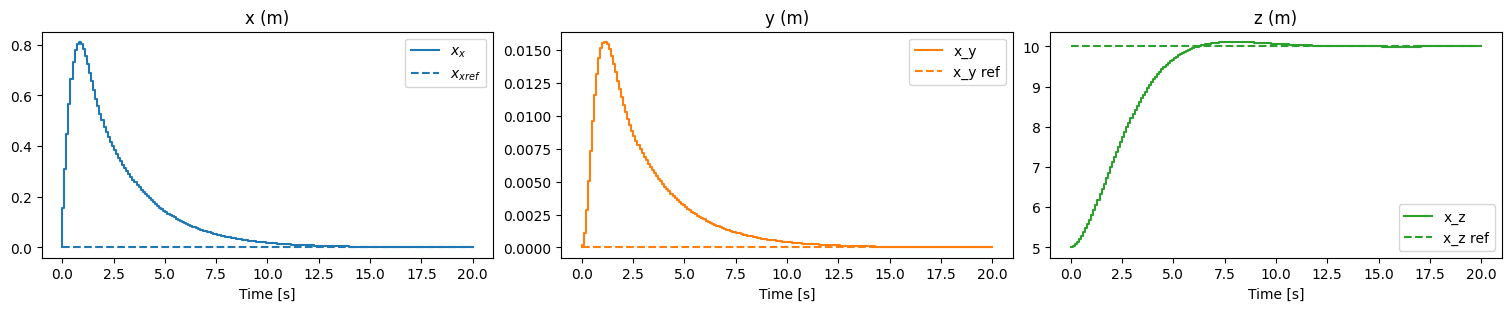

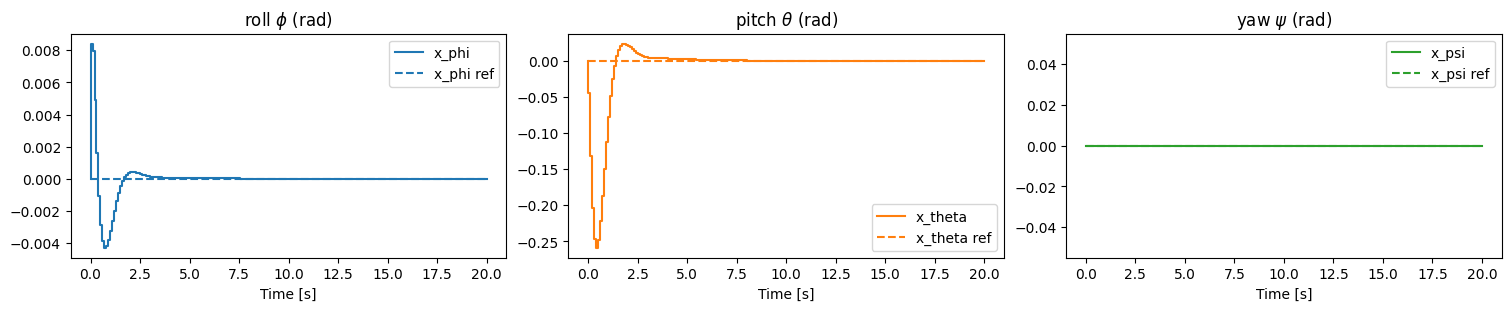

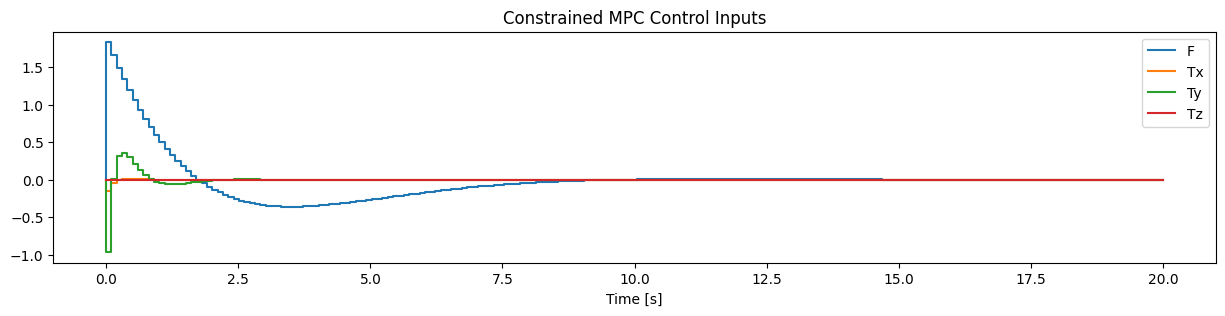

In [22]:
# Visualization

## x,y,z plotting
fig, axs = plt.subplots(1,3, figsize=(15,3), constrained_layout=True)
axs[0].step(time, x_bag[0, :], '#1f77b4', label=r'$x_x$')
axs[0].step(time, x_ref[0,:], '#1f77b4', linestyle='--', label=r'$x_{xref}$')

axs[1].step(time, x_bag[1, :], '#ff7f0e', label="x_y")
axs[1].step(time, x_ref[1,:], '#ff7f0e', linestyle='--', label="x_y ref")

axs[2].step(time, x_bag[2, :], '#2ca02c', label="x_z")
axs[2].step(time, x_ref[2,:], '#2ca02c', linestyle='--', label="x_z ref")

#plt.step(x_bag[5, :], '#d62728', label="x_psi")
for ax, title in zip(axs, ['x (m)','y (m)','z (m)']):
    ax.set_xlabel("Time [s]")
    ax.set_title(f'{title}')
    ax.legend()
plt.show()

## x,y,z plotting
fig, axs = plt.subplots(1,3, figsize=(15,3), constrained_layout=True)
axs[0].step(time, x_bag[3, :], '#1f77b4', label="x_phi")
axs[0].step(time, x_ref[3,:], '#1f77b4', linestyle='--', label="x_phi ref")

axs[1].step(time, x_bag[4, :], '#ff7f0e', label="x_theta")
axs[1].step(time, x_ref[4,:], '#ff7f0e', linestyle='--', label="x_theta ref")

axs[2].step(time, x_bag[5, :], '#2ca02c', label="x_psi")
axs[2].step(time, x_ref[5,:], '#2ca02c', linestyle='--', label="x_psi ref")

#plt.step(x_bag[5, :], '#d62728', label="x_psi")
for ax, title in zip(axs, [r'roll $\phi$ (rad)',r'pitch $\theta$ (rad)',r'yaw $\psi$ (rad)']):
    ax.set_xlabel("Time [s]")
    ax.set_title(title)
    ax.legend()
plt.show()

plt.figure(figsize=(15,3))
plt.step(time, u_bag[0, :], '#1f77b4', label="F")
plt.step(time, u_bag[1, :], '#ff7f0e', label="Tx")
plt.step(time,u_bag[2, :], '#2ca02c', label="Ty")
plt.step(time, u_bag[3, :], '#d62728', label="Tz")
plt.xlabel("Time [s]")
plt.title("Constrained MPC Control Inputs")
plt.legend()
plt.show()